In [1]:
import cv2
import gc
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf
import warnings

from itertools import chain
from PIL import Image
from skimage.io import imread, imshow, concatenate_images
from skimage.morphology import label
from skimage.transform import resize
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import *
from tqdm.notebook import trange, tqdm

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['KERAS_BACKEND']='tensorflow'

warnings.filterwarnings('ignore')
plt.style.use("ggplot")

In [3]:
def iou(y_true, y_pred):
    y_true = y_true.astype(np.bool)
    y_pred = y_pred.astype(np.bool)
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

# 影像前處理

In [4]:
img_size = (256, 256)
learning_rate = 0.001
batch_size = 2
epochs = 40

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [5]:
# 訓練資料_Image
# 設定文件夾路徑和圖像大小
X_train_path = "C://ETT_v3/Fold1/train/"
y_train_path = "C://ETT_v3/Fold1/trainannot/"

# 取得文件夾中所有的圖像檔名
X_train_names = os.listdir(X_train_path)
y_train_names = os.listdir(y_train_path)

# 初始化空的numpy陣列以儲存圖像
X_train = np.zeros((len(X_train_names)*3, img_size[0], img_size[1], 1))
y_train = np.zeros((len(y_train_names)*3, img_size[0], img_size[1], 1))

# 遍歷每個圖檔，使用Load_img()讀取圖檔
for i, X_name in enumerate(X_train_names):
    img = load_img(X_train_path + X_name, target_size=img_size)
    img_arr = np.array(img)
    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    X_train[i] = img_gray.reshape((256, 256, 1))
    
    # 對比度處理 
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_gray)
    img_clahe_reshaped = img_clahe.reshape((256, 256, 1))
    X_train[i+len(X_train_names)] = img_clahe_reshaped
    
    # 水平翻轉處理
    img_flipped = cv2.flip(img_clahe_reshaped, 1).reshape((256, 256, 1))
    X_train[i+len(X_train_names)*2] = img_flipped

print("Train image data shape:", X_train.shape)

# 訓練資料_mask
for i, y_name in enumerate(y_train_names):
    img = load_img(y_train_path + y_name, target_size=img_size)
    img_arr = np.array(img)
    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY).reshape((256, 256, 1))
    y_train[i] = img_gray
    y_train[i+len(X_train_names)] = img_gray
    
    # 水平翻轉處理
    img_flipped = cv2.flip(img_gray, 1).reshape((256, 256, 1))
    y_train[i+len(X_train_names)*2] = img_flipped
    
# 二值化
y_train = np.where(y_train > 127, 1, 0)

print("Train mask data shape:", y_train.shape)

Train image data shape: (861, 256, 256, 1)
Train mask data shape: (861, 256, 256, 1)


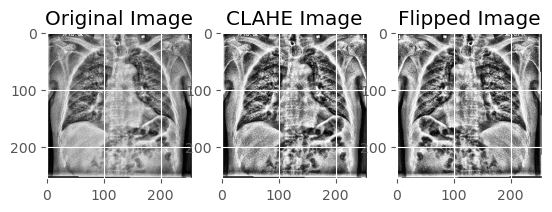

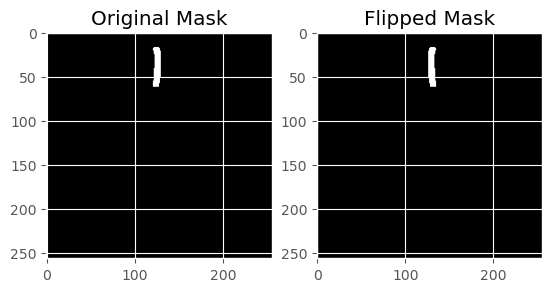

In [6]:
# 顯示原始圖像、對比強化後和水平翻轉後的圖像(第一張為例)
index = 0

plt.subplot(1, 3, 1)
plt.imshow(X_train[index].astype('uint8'), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(X_train[index+len(X_train_names)].astype('uint8'), cmap='gray')
plt.title('CLAHE Image')

plt.subplot(1, 3, 3)
plt.imshow(X_train[index+len(X_train_names)*2].astype('uint8'), cmap='gray')
plt.title('Flipped Image')
plt.show()

# 顯示原始mask、水平翻轉後的mask(第一張為例)
plt.subplot(1, 2, 1)
plt.imshow(y_train[index].astype('uint8'), cmap='gray')
plt.title('Original Mask')

plt.subplot(1, 2, 2)
plt.imshow(y_train[index+len(y_train_names)*2].astype('uint8'), cmap='gray')
plt.title('Flipped Mask')
plt.show()

In [7]:
# 驗證資料
X_val_path = "C://ETT_v3/Fold1/val/"
y_val_path = "C://ETT_v3/Fold1/valannot/"

X_val_names = os.listdir(X_val_path)
y_val_names = os.listdir(y_val_path)

X_val = np.zeros((len(X_val_names), img_size[0], img_size[1], 1))
y_val = np.zeros((len(y_val_names), img_size[0], img_size[1], 1))

for i, X_name in enumerate(X_val_names):
    img = load_img(X_val_path + X_name, target_size=img_size)
    img_arr = np.array(img)
    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    X_val[i] = img_gray.reshape((256, 256, 1))

print("Val image data shape:", X_val.shape)

for i, y_name in enumerate(y_val_names):
    img = load_img(y_val_path + y_name, target_size=img_size)
    img_arr = np.array(img)
    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    y_val[i] = img_gray.reshape((256, 256, 1))
    
y_val = np.where(y_val > 127, 1, 0)

print("Val mask data shape:", y_val.shape)

Val image data shape: (47, 256, 256, 1)
Val mask data shape: (47, 256, 256, 1)


In [8]:
# 測試資料
X_test_path = "C://ETT_v3/Fold1/test/"
y_test_path = "C://ETT_v3/Fold1/testannot/"

X_test_names = os.listdir(X_test_path)
y_test_names = os.listdir(y_test_path)

X_test = np.zeros((len(X_test_names), img_size[0], img_size[1], 1))
y_test = np.zeros((len(y_test_names), img_size[0], img_size[1], 1))
original = {}

for i, X_name in enumerate(X_test_names):
    img = load_img(X_test_path + X_name, target_size=img_size)
    img_arr = np.array(img)
    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    X_test[i] = img_gray.reshape((256, 256, 1))

print("Test image data shape:", X_test.shape)

for i, y_name in enumerate(y_test_names):
    # 取得遮罩原圖尺寸
    original_img = Image.open(os.path.join(y_test_path, y_name))
    original_img_arr = np.array(original_img)
    original_img_gary = cv2.cvtColor(original_img_arr, cv2.COLOR_BGR2GRAY)
    original[i] = {'img': original_img_gary, 'img_size': original_img.size}
    
    img = load_img(y_test_path + y_name, target_size=img_size)
    img_arr = np.array(img)
    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    y_test[i] = img_gray.reshape((256, 256, 1))
    
y_test = np.where(y_test > 127, 1, 0)

print("Test mask data shape:", y_test.shape)

Test image data shape: (47, 256, 256, 1)
Test mask data shape: (47, 256, 256, 1)


# U-Net

In [9]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [10]:
def Unet(input_img, n_filters = 2, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [11]:
K.clear_session()

input_img = Input((256, 256, 1), name='img')
model = Unet(input_img, n_filters=1, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss="binary_crossentropy", metrics=tf.keras.metrics.AUC())
gc.collect()

291

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 1)  10          ['img[0][0]']                    
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256, 256, 1)  4          ['conv2d_1[0][0]']               
 rmalization)                                                                                     
                                                                                              

 ormalization)                                                                                    
                                                                                                  
 activation_13 (Activation)     (None, 64, 64, 4)    0           ['batch_normalization_13[0][0]'] 
                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 128, 128, 2)  74         ['activation_13[0][0]']          
 spose)                                                                                           
                                                                                                  
 concatenate_2 (Concatenate)    (None, 128, 128, 4)  0           ['conv2d_transpose_2[0][0]',     
                                                                  'activation_3[0][0]']           
                                                                                                  
 dropout_6

In [13]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-Unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("Unet.csv")
]

In [14]:
results = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val),
                    use_multiprocessing=True)

Epoch 1/40
431/431 [==============================] - ETA: 0s - loss: 0.3774 - auc: 0.4961
Epoch 1: val_loss improved from inf to 0.23191, saving model to model-Unet.h5
431/431 [==============================] - 10s 16ms/step - loss: 0.3774 - auc: 0.4961 - val_loss: 0.2319 - val_auc: 0.5197 - lr: 0.0010
Epoch 2/40
430/431 [============================>.] - ETA: 0s - loss: 0.1720 - auc: 0.5614
Epoch 2: val_loss improved from 0.23191 to 0.10109, saving model to model-Unet.h5
431/431 [==============================] - 6s 15ms/step - loss: 0.1719 - auc: 0.5614 - val_loss: 0.1011 - val_auc: 0.4987 - lr: 0.0010
Epoch 3/40
431/431 [==============================] - ETA: 0s - loss: 0.0919 - auc: 0.7810
Epoch 3: val_loss improved from 0.10109 to 0.06075, saving model to model-Unet.h5
431/431 [==============================] - 7s 16ms/step - loss: 0.0919 - auc: 0.7810 - val_loss: 0.0607 - val_auc: 0.4990 - lr: 0.0010
Epoch 4/40
429/431 [============================>.] - ETA: 0s - loss: 0.0549 - 

Epoch 29/40
431/431 [==============================] - ETA: 0s - loss: 0.0184 - auc: 0.9850
Epoch 29: val_loss improved from 0.01794 to 0.01783, saving model to model-Unet.h5
431/431 [==============================] - 7s 16ms/step - loss: 0.0184 - auc: 0.9850 - val_loss: 0.0178 - val_auc: 0.9749 - lr: 1.0000e-04
Epoch 30/40
431/431 [==============================] - ETA: 0s - loss: 0.0183 - auc: 0.9852
Epoch 30: val_loss did not improve from 0.01783
431/431 [==============================] - 7s 16ms/step - loss: 0.0183 - auc: 0.9852 - val_loss: 0.0178 - val_auc: 0.9726 - lr: 1.0000e-04
Epoch 31/40
428/431 [============================>.] - ETA: 0s - loss: 0.0182 - auc: 0.9856
Epoch 31: val_loss improved from 0.01783 to 0.01782, saving model to model-Unet.h5
431/431 [==============================] - 7s 16ms/step - loss: 0.0182 - auc: 0.9856 - val_loss: 0.0178 - val_auc: 0.9737 - lr: 1.0000e-04
Epoch 32/40
428/431 [============================>.] - ETA: 0s - loss: 0.0182 - auc: 0.9851
E

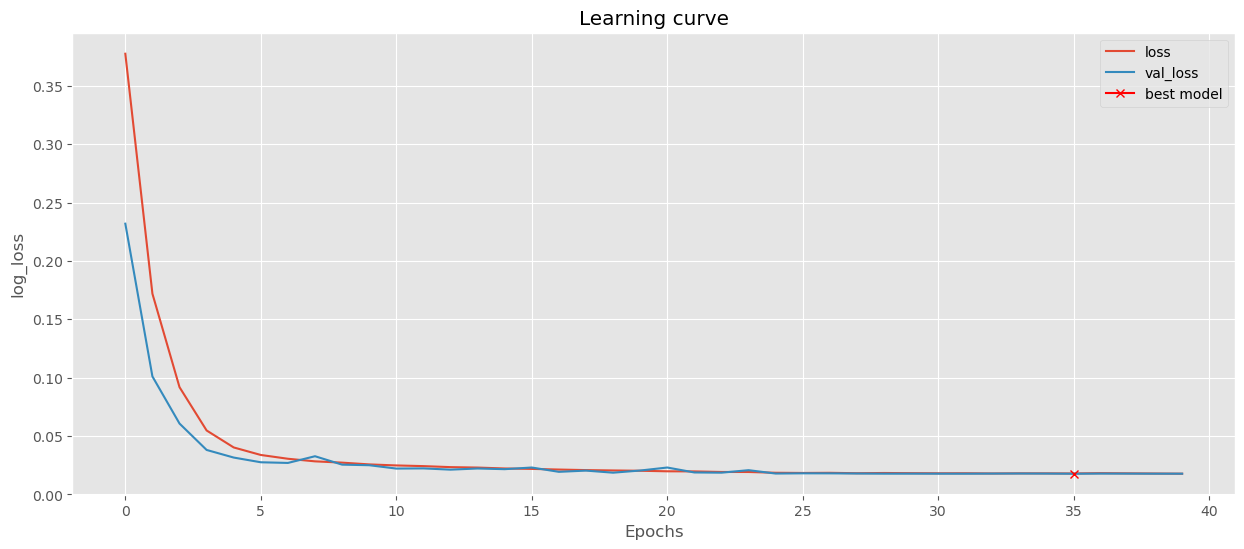

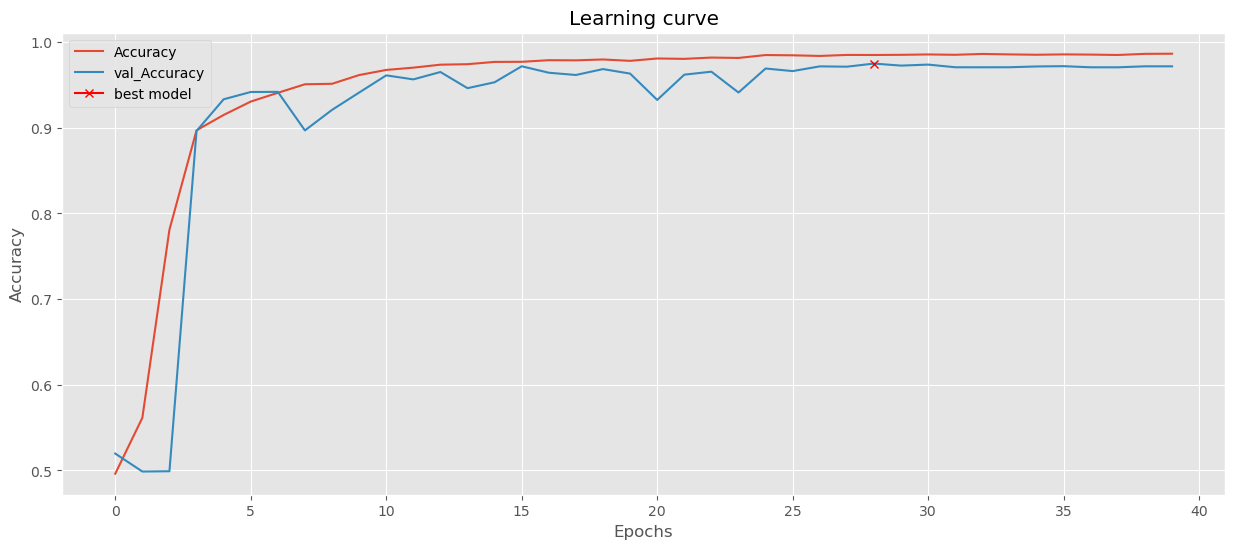

In [15]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["auc"], label="Accuracy")
plt.plot(results.history["val_auc"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_auc"]), np.max(results.history["val_auc"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [16]:
model.load_weights('model-Unet.h5')

In [17]:
model.evaluate(X_test, y_test, verbose=1)

2/2 [==============================] - 1s 130ms/step - loss: 0.0138 - auc: 0.9923


[0.013840881176292896, 0.992250382900238]

In [20]:
preds = model.predict(X_test, verbose=1)

2/2 [==============================] - 0s 45ms/step


In [21]:
#二值化
print(np.unique(preds))

preds = np.where(preds >= 5.0512636e-01, 1, 0)

print(np.unique(preds))

[8.6936807e-06 1.0600230e-05 1.0818870e-05 ... 5.0451809e-01 5.0455582e-01
 5.0512636e-01]
[0 1]


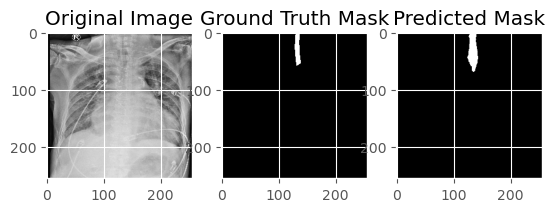

In [22]:
# 顯示原始圖像、原始mask和預測mask(第一張為例)
index = 0

plt.subplot(1, 3, 1)
plt.imshow(X_test[index], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(y_test[index], cmap='gray')
plt.title('Ground Truth Mask')

plt.subplot(1, 3, 3)
plt.imshow(preds[index], cmap='gray')
plt.title('Predicted Mask')
plt.show()

In [23]:
# 計算預測結果的IOU
iou_score = iou(y_test, preds)

print('IOU: ', iou_score)

IOU:  0.4577677916360968


In [24]:
# 計算所有圖像中最下面端點的誤差（以像素為單位）
total_error = 0
num_error_half = 0
num_error_one = 0
num_images = len(y_test)

for i in range(num_images):
    
    # 找到原始遮罩中的端點
    binary_img = cv2.convertScaleAbs(original[i]['img'])
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    bottom_point_gt = tuple(max_contour[max_contour[:,:,1].argmax()][0])
    
    # 找到預測遮罩中的端點
    pred_mask_uint8 = preds[i].astype(np.uint8) # 將預測的遮罩轉換為8位無符號整數類型
    resized_pred_mask = cv2.resize(pred_mask_uint8, original[i]['img_size']) # 縮放預測的遮罩為原始尺寸
    binary_img = cv2.convertScaleAbs(resized_pred_mask) # 將縮放後的遮罩轉為二值圖像
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    bottom_point_pred  = tuple(max_contour[max_contour[:,:,1].argmax()][0])

    # 計算端點的誤差（以像素為單位）
    error_pixels = np.abs(bottom_point_gt[1] - bottom_point_pred[1])
    
    # 將誤差從像素轉換為公分
    error_cm = error_pixels / 72
    
    # 加入總誤差中
    total_error += error_cm
    
    # 如果誤差<=0.5公分、<=1公分，則將符合條件的樣本數加1
    if error_cm <= 0.5:
        num_error_half += 1
    
    if error_cm <= 1:
        num_error_one += 1

# 計算平均誤差（以公分為單位）
mean_error_cm = total_error / num_images

# 計算誤差<=0.5公分、<=1公分的準確率
accuracy_half = num_error_half / num_images
accuracy_one = num_error_one / num_images

print('平均誤差（公分）:', mean_error_cm)
print('誤差小於等於0.5公分的準確率:', accuracy_half*100, '%')
print('誤差小於等於1公分的準確率:', accuracy_one*100, '%')

平均誤差（公分）: 1.7727541371158388
誤差小於等於0.5公分的準確率: 25.53191489361702 %
誤差小於等於1公分的準確率: 38.297872340425535 %


Bottom point: (1323, 833)


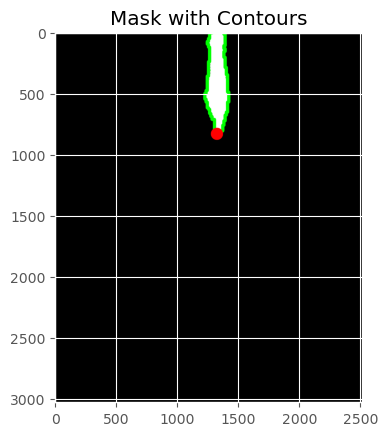

In [25]:
# 顯示預測遮罩的輪廓和端點(以第一張為例)
index = 0

# 將預測圖像轉換為CV_8UC1格式
pred_mask_uint8 = preds[index].astype(np.uint8) *255

# 縮放預測的遮罩為原始尺寸
resized_pred_mask = cv2.resize(pred_mask_uint8, original[i]['img_size'])

# 將縮放後的遮罩轉為二值圖像
binary_img = cv2.convertScaleAbs(resized_pred_mask)

# 執行輪廓檢測
contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 找到最大的輪廓
max_contour = max(contours, key=cv2.contourArea)

# 找到最下面的點
bottom_point_pred = tuple(max_contour[max_contour[:,:,1].argmax()][0])

# 輸出端點
print("Bottom point:", bottom_point_pred)

# 创建彩色图像
contour_image = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2RGB)

# 绘制轮廓
cv2.drawContours(contour_image, [max_contour], -1, (0, 255, 0), 25)

# 绘制端点
cv2.circle(contour_image, bottom_point_pred, 50, (255, 0, 0), -1)

# 显示图像
plt.imshow(contour_image)
plt.title('Mask with Contours')
plt.show()

# U-Net++

In [26]:
dropout_rate = 0.5

def conv_batchnorm_relu_block(input_tensor, nb_filter, kernel_size=3):

    x = Conv2D(nb_filter, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = BatchNormalization(axis=2)(x)
    x = Activation('relu')(x)

    return x


def UnetPP(input_shape, n_labels, using_deep_supervision=False):

    nb_filter = [32,64,128,256,512]

    # Set image data format to channels first
    global bn_axis

    K.set_image_data_format("channels_last")
    bn_axis = -1
    inputs = Input(shape=input_shape, name='input_image')

    conv1_1 = conv_batchnorm_relu_block(inputs, nb_filter=nb_filter[0])
    pool1 = AvgPool2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = conv_batchnorm_relu_block(pool1, nb_filter=nb_filter[1])
    pool2 = AvgPool2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = conv_batchnorm_relu_block(conv1_2,  nb_filter=nb_filter[0])

    conv3_1 = conv_batchnorm_relu_block(pool2, nb_filter=nb_filter[2])
    pool3 = AvgPool2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = conv_batchnorm_relu_block(conv2_2, nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = conv_batchnorm_relu_block(conv1_3, nb_filter=nb_filter[0])

    conv4_1 = conv_batchnorm_relu_block(pool3, nb_filter=nb_filter[3])
    pool4 = AvgPool2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = conv_batchnorm_relu_block(conv3_2, nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = conv_batchnorm_relu_block(conv2_3, nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = conv_batchnorm_relu_block(conv1_4, nb_filter=nb_filter[0])

    conv5_1 = conv_batchnorm_relu_block(pool4, nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = conv_batchnorm_relu_block(conv4_2, nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = conv_batchnorm_relu_block(conv3_3, nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = conv_batchnorm_relu_block(conv2_4, nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = conv_batchnorm_relu_block(conv1_5, nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_1',padding='same')(conv1_2)
    nestnet_output_2 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_2', padding='same' )(conv1_3)
    nestnet_output_3 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_3', padding='same')(conv1_4)
    nestnet_output_4 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_4', padding='same')(conv1_5)

    if using_deep_supervision:
        model = Model(input=inputs, output=[nestnet_output_1,
                                            nestnet_output_2,
                                            nestnet_output_3,
                                            nestnet_output_4])
    else:
        model = Model(inputs=inputs, outputs=nestnet_output_4)

    return model

In [27]:
K.clear_session()

model = UnetPP(input_shape = (256, 256, 1), n_labels=1)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=tf.keras.metrics.AUC())
gc.collect()

23573

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  1024       ['conv2d[0][0]']                 
 alization)                     )                                                             

 rmalization)                                                                                     
                                                                                                  
 conv2d_4 (Conv2D)              (None, 128, 128, 64  73792       ['merge22[0][0]']                
                                )                                                                 
                                                                                                  
 merge12 (Concatenate)          (None, 256, 256, 64  0           ['up12[0][0]',                   
                                )                                 'activation[0][0]']             
                                                                                                  
 up33 (Conv2DTranspose)         (None, 64, 64, 128)  131200      ['activation_11[0][0]']          
                                                                                                  
 activatio

                                                                                                  
 merge14 (Concatenate)          (None, 256, 256, 12  0           ['up14[0][0]',                   
                                8)                                'activation[0][0]',             
                                                                  'activation_2[0][0]',           
                                                                  'activation_5[0][0]']           
                                                                                                  
 batch_normalization_13 (BatchN  (None, 128, 128, 64  512        ['conv2d_13[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 256, 256, 32  36896       ['merge14[0][0]']                
          

In [29]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-UnetPP.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataUnetPP.csv"),
    TensorBoard(log_dir='./logs')
]

In [30]:
results = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val),
                    use_multiprocessing=True)

Epoch 1/40
431/431 [==============================] - ETA: 0s - loss: 0.0393 - auc: 0.9318
Epoch 1: val_loss improved from inf to 0.02649, saving model to model-UnetPP.h5
431/431 [==============================] - 39s 79ms/step - loss: 0.0393 - auc: 0.9318 - val_loss: 0.0265 - val_auc: 0.9760 - lr: 0.0010
Epoch 2/40
431/431 [==============================] - ETA: 0s - loss: 0.0227 - auc: 0.9801
Epoch 2: val_loss improved from 0.02649 to 0.02333, saving model to model-UnetPP.h5
431/431 [==============================] - 32s 75ms/step - loss: 0.0227 - auc: 0.9801 - val_loss: 0.0233 - val_auc: 0.9843 - lr: 0.0010
Epoch 3/40
431/431 [==============================] - ETA: 0s - loss: 0.0187 - auc: 0.9860
Epoch 3: val_loss improved from 0.02333 to 0.02014, saving model to model-UnetPP.h5
431/431 [==============================] - 32s 75ms/step - loss: 0.0187 - auc: 0.9860 - val_loss: 0.0201 - val_auc: 0.9894 - lr: 0.0010
Epoch 4/40
431/431 [==============================] - ETA: 0s - loss: 0

Epoch 28/40
431/431 [==============================] - ETA: 0s - loss: 0.0055 - auc: 0.9986
Epoch 28: val_loss did not improve from 0.00865
431/431 [==============================] - 32s 75ms/step - loss: 0.0055 - auc: 0.9986 - val_loss: 0.0087 - val_auc: 0.9909 - lr: 1.0000e-05
Epoch 29/40
431/431 [==============================] - ETA: 0s - loss: 0.0055 - auc: 0.9986
Epoch 29: val_loss did not improve from 0.00865
431/431 [==============================] - 32s 75ms/step - loss: 0.0055 - auc: 0.9986 - val_loss: 0.0087 - val_auc: 0.9917 - lr: 1.0000e-05
Epoch 30/40
431/431 [==============================] - ETA: 0s - loss: 0.0054 - auc: 0.9986
Epoch 30: val_loss did not improve from 0.00865
431/431 [==============================] - 32s 75ms/step - loss: 0.0054 - auc: 0.9986 - val_loss: 0.0088 - val_auc: 0.9916 - lr: 1.0000e-05
Epoch 31/40
431/431 [==============================] - ETA: 0s - loss: 0.0054 - auc: 0.9986
Epoch 31: val_loss did not improve from 0.00865
431/431 [===========

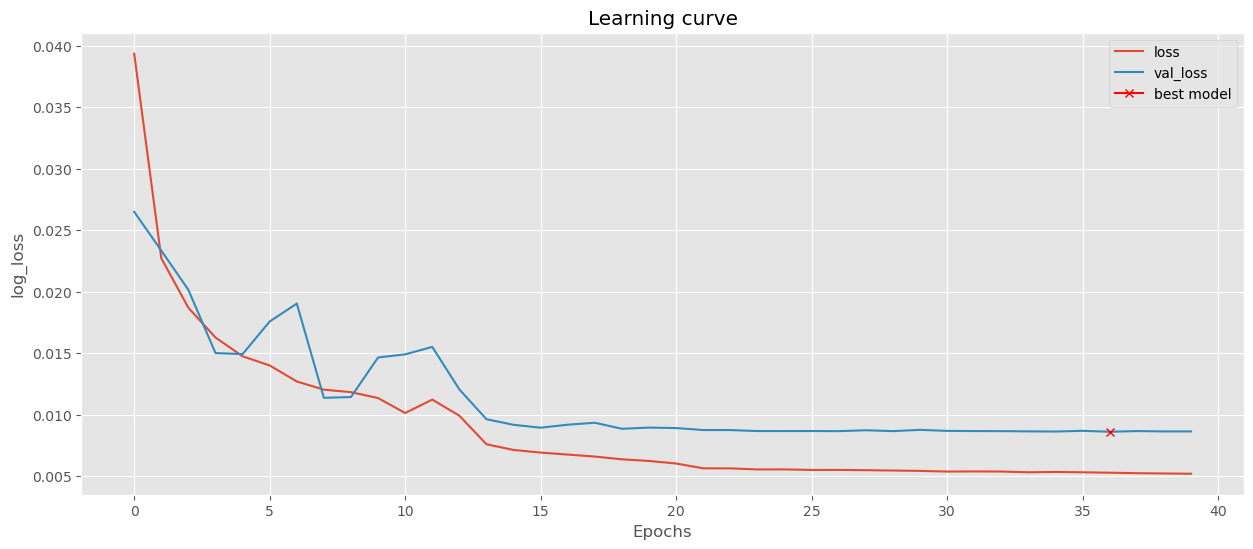

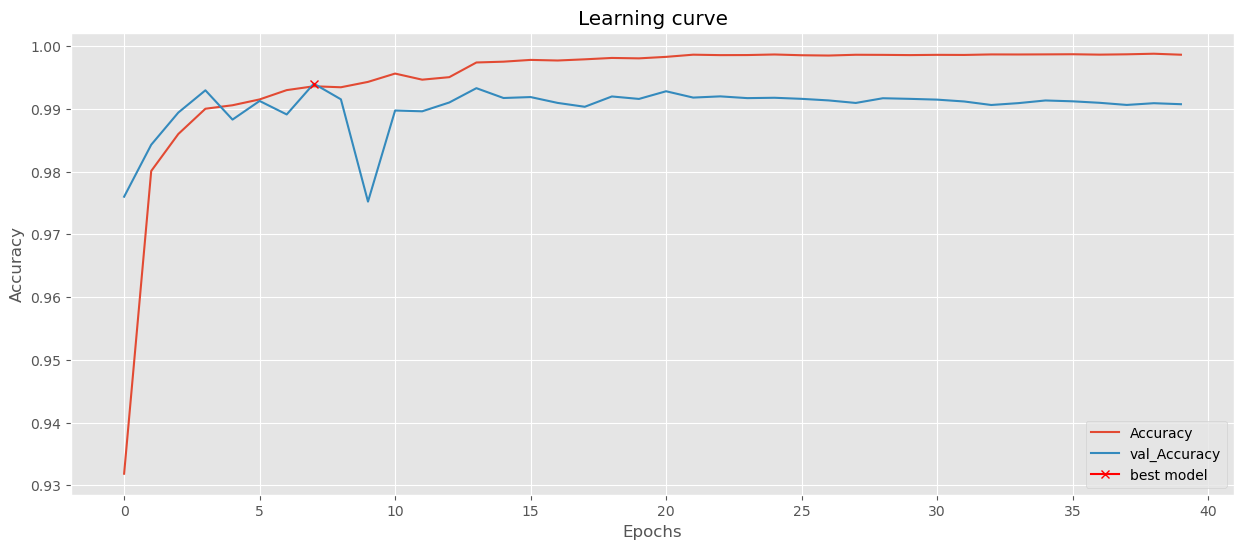

In [31]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["auc"], label="Accuracy")
plt.plot(results.history["val_auc"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_auc"]), np.max(results.history["val_auc"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [32]:
model.load_weights('model-UnetPP.h5')

In [33]:
model.evaluate(X_test, y_test, verbose=1)

2/2 [==============================] - 4s 1s/step - loss: 0.0065 - auc: 0.9971


[0.006511811167001724, 0.9970574975013733]

In [76]:
preds = model.predict(X_test, verbose=1)

2/2 [==============================] - 0s 384ms/step


In [77]:
#二值化
print(np.unique(preds))

preds = np.where(preds >= 0.6, 1, 0)

print(np.unique(preds))

[3.2611097e-12 4.5648797e-12 5.2028464e-12 ... 9.9996042e-01 9.9996090e-01
 9.9996305e-01]
[0 1]


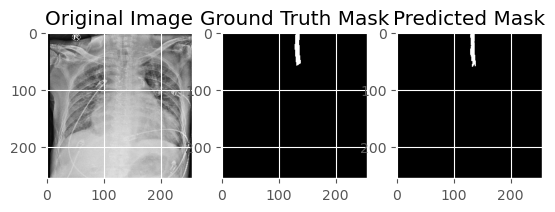

In [78]:
# 顯示原始圖像、原始mask和預測mask(第一張為例)
index = 0

plt.subplot(1, 3, 1)
plt.imshow(X_test[index], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(y_test[index], cmap='gray')
plt.title('Ground Truth Mask')

plt.subplot(1, 3, 3)
plt.imshow(preds[index], cmap='gray')
plt.title('Predicted Mask')
plt.show()

In [79]:
# 計算預測結果的IOU
iou_score = iou(y_test, preds)

print('IOU: ', iou_score)

IOU:  0.7011524555589033


In [80]:
# 計算所有圖像中最下面端點的誤差（以像素為單位）
total_error = 0
num_error_half = 0
num_error_one = 0
num_images = len(y_test)

for i in range(num_images):
    
    # 找到原始遮罩中的端點
    binary_img = cv2.convertScaleAbs(original[i]['img'])
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    bottom_point_gt = tuple(max_contour[max_contour[:,:,1].argmax()][0])
    
    # 找到預測遮罩中的端點
    pred_mask_uint8 = preds[i].astype(np.uint8) # 將預測的遮罩轉換為8位無符號整數類型
    resized_pred_mask = cv2.resize(pred_mask_uint8, original[i]['img_size']) # 縮放預測的遮罩為原始尺寸
    binary_img = cv2.convertScaleAbs(resized_pred_mask) # 將縮放後的遮罩轉為二值圖像
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    bottom_point_pred  = tuple(max_contour[max_contour[:,:,1].argmax()][0])

    # 計算端點的誤差（以像素為單位）
    error_pixels = np.abs(bottom_point_gt[1] - bottom_point_pred[1])
    
    # 將誤差從像素轉換為公分
    error_cm = error_pixels / 72
    
    # 加入總誤差中
    total_error += error_cm
    
    # 如果誤差<=0.5公分、<=1公分，則將符合條件的樣本數加1
    if error_cm <= 0.5:
        num_error_half += 1
    
    if error_cm <= 1:
        num_error_one += 1

# 計算平均誤差（以公分為單位）
mean_error_cm = total_error / num_images

# 計算誤差<=0.5公分、<=1公分的準確率
accuracy_half = num_error_half / num_images
accuracy_one = num_error_one / num_images

print('平均誤差（公分）:', mean_error_cm)
print('誤差小於等於0.5公分的準確率:', accuracy_half*100, '%')
print('誤差小於等於1公分的準確率:', accuracy_one*100, '%')

平均誤差（公分）: 0.7559101654846337
誤差小於等於0.5公分的準確率: 46.808510638297875 %
誤差小於等於1公分的準確率: 72.3404255319149 %


Bottom point: (1303, 726)


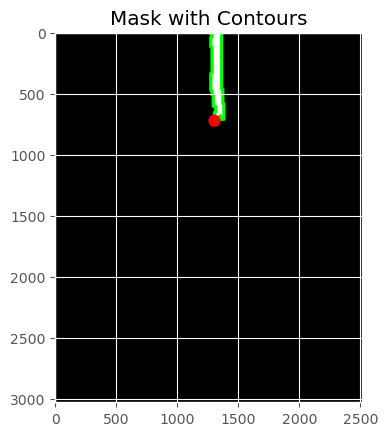

In [81]:
# 顯示預測遮罩的輪廓和端點(以第一張為例)
index = 0

# 將預測圖像轉換為CV_8UC1格式
pred_mask_uint8 = preds[index].astype(np.uint8) *255

# 縮放預測的遮罩為原始尺寸
resized_pred_mask = cv2.resize(pred_mask_uint8, original[i]['img_size'])

# 將縮放後的遮罩轉為二值圖像
binary_img = cv2.convertScaleAbs(resized_pred_mask)

# 執行輪廓檢測
contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 找到最大的輪廓
max_contour = max(contours, key=cv2.contourArea)

# 找到最下面的點
bottom_point_pred = tuple(max_contour[max_contour[:,:,1].argmax()][0])

# 輸出端點
print("Bottom point:", bottom_point_pred)

# 创建彩色图像
contour_image = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2RGB)

# 绘制轮廓
cv2.drawContours(contour_image, [max_contour], -1, (0, 255, 0), 25)

# 绘制端点
cv2.circle(contour_image, bottom_point_pred, 50, (255, 0, 0), -1)

# 显示图像
plt.imshow(contour_image)
plt.title('Mask with Contours')
plt.show()